In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from sklearn.metrics import roc_auc_score
import gc #importing garbage collector
import time
from scipy import signal



import warnings
warnings.filterwarnings('ignore')

%matplotlib inline  

SEED = 42
#Pandas - Displaying more rorws and columns
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)


Bad key "text.kerning_factor" on line 4 in
C:\Users\Mac\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Load Data and reduce the memory usage

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
timesteps = 14
startDay = 0

In [4]:
df_train = pd.read_csv('m5-forecasting-uncertainty/sales_train_validation.csv')
df_prices = pd.read_csv('m5-forecasting-uncertainty/sell_prices.csv')
df_days = pd.read_csv('m5-forecasting-uncertainty/calendar.csv')

df_train = reduce_mem_usage(df_train)
df_prices = reduce_mem_usage(df_prices)
df_days = reduce_mem_usage(df_days)

Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to  0.12 Mb (41.9% reduction)


## EDA about hierachy

In [5]:
series_cols = df_train.columns[df_train.columns.str.contains("d_")].values
level_cols = df_train.columns[df_train.columns.str.contains("d_")==False].values

In [6]:
df_train.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,2,2,0,0,0,1,1,0,2,0,1,1,2,0,1,0,0,0,2,1,0,1,1,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1

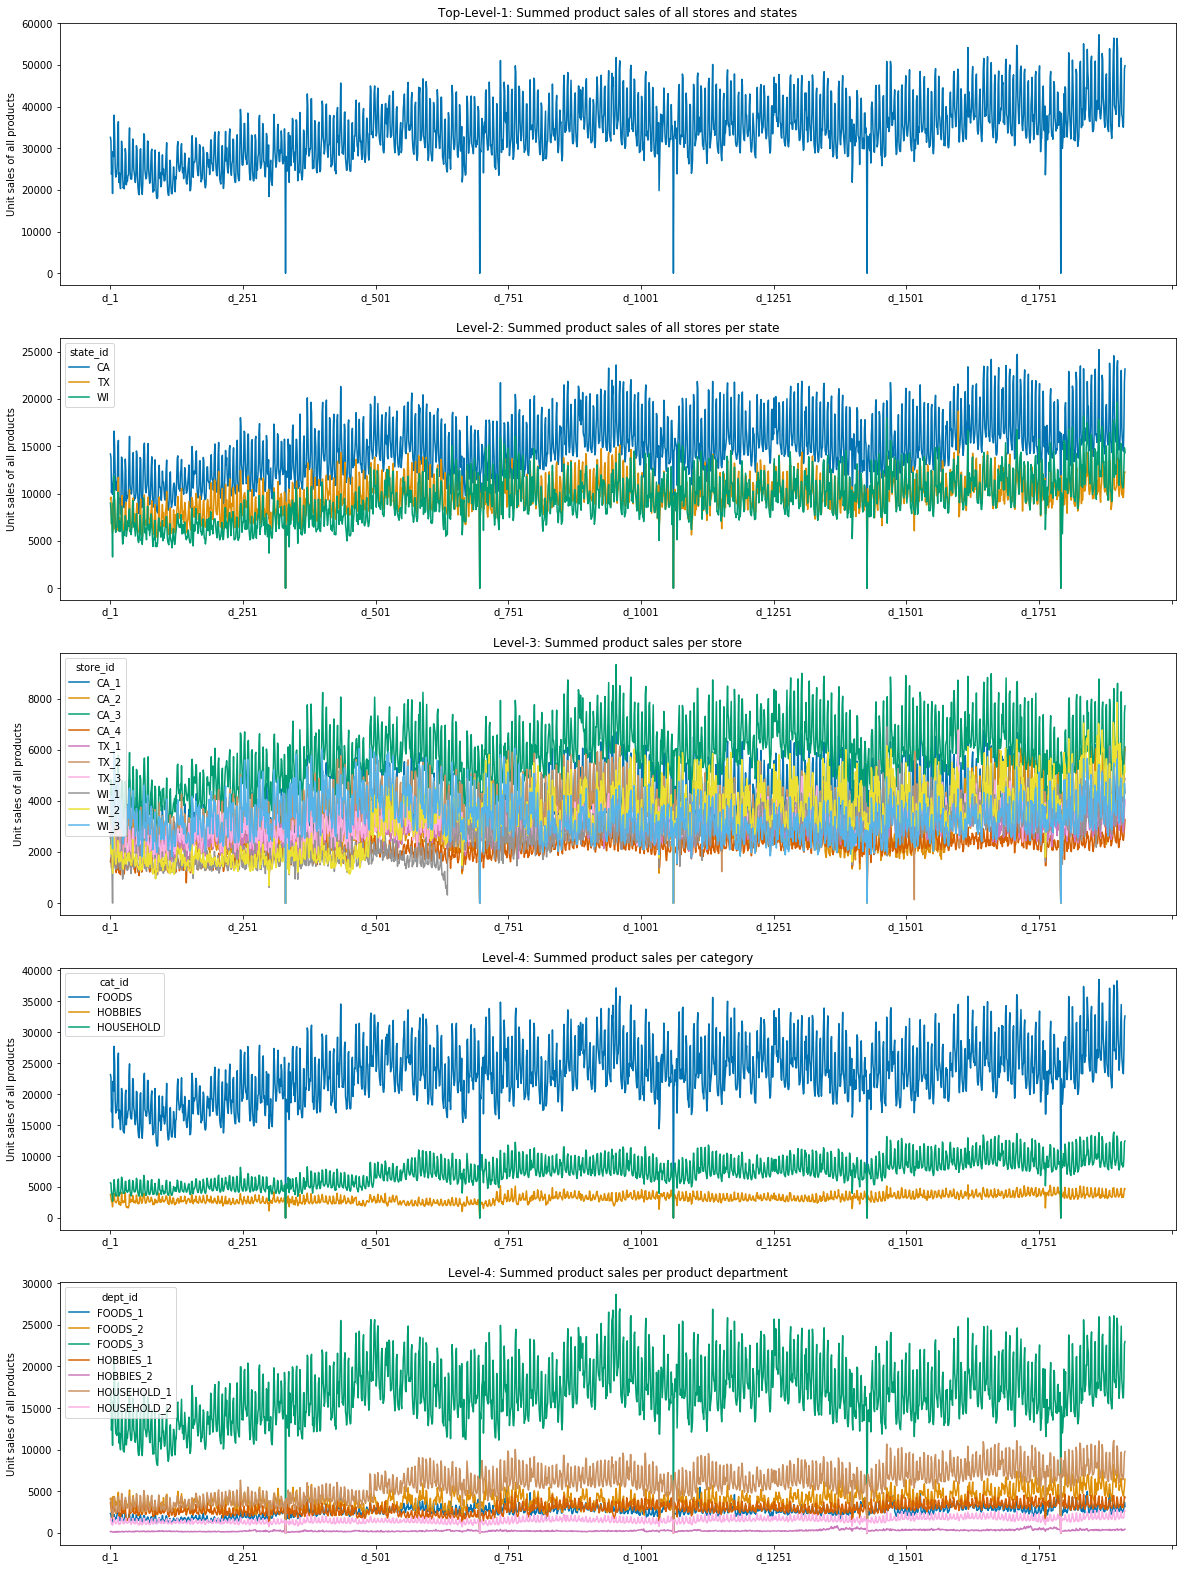

In [7]:
sns.set_palette("colorblind")

fig, ax = plt.subplots(5,1,figsize=(20,28))
df_train[series_cols].sum().plot(ax=ax[0])
ax[0].set_title("Top-Level-1: Summed product sales of all stores and states")
ax[0].set_ylabel("Unit sales of all products");
df_train.groupby("state_id")[series_cols].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Level-2: Summed product sales of all stores per state");
ax[1].set_ylabel("Unit sales of all products");
df_train.groupby("store_id")[series_cols].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Level-3: Summed product sales per store")
ax[2].set_ylabel("Unit sales of all products");
df_train.groupby("cat_id")[series_cols].sum().transpose().plot(ax=ax[3])
ax[3].set_title("Level-4: Summed product sales per category")
ax[3].set_ylabel("Unit sales of all products");
df_train.groupby("dept_id")[series_cols].sum().transpose().plot(ax=ax[4])
ax[4].set_title("Level-4: Summed product sales per product department")
ax[4].set_ylabel("Unit sales of all products");

### Insights
#### 1.It has become much clearer how these levels are aggregated by performing groupby- and summing up the sales.
#### 2.We can already observe nice periodic patterns.

## Outliers

Text(0.5,0,'Days')

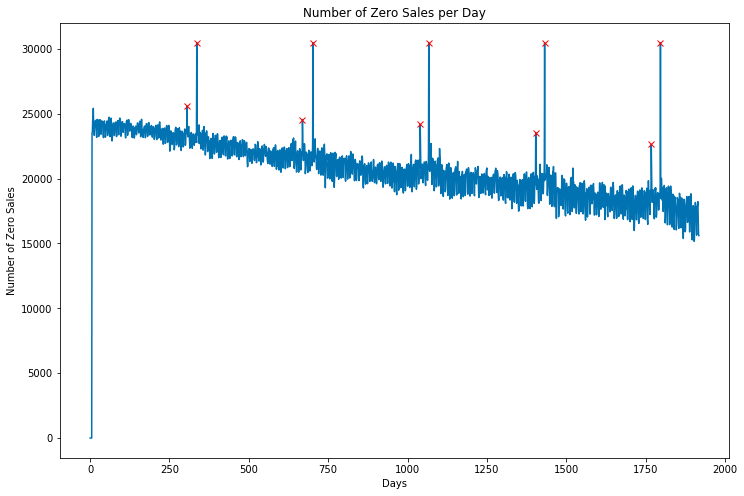

In [8]:
temp_series = df_train
plt.figure(figsize=(12,8))
peak_days = []
x = np.count_nonzero(temp_series==0, axis=0)
peaks, _ = sc.signal.find_peaks(x, height=np.quantile(x,0.75), threshold=max(x)/25)
peak_d = temp_series.columns[peaks]
peak_days=peak_d
plt.plot(x)
plt.plot(peaks, x[peaks], "x", color='red')
    
plt.title('Number of Zero Sales per Day')
plt.ylabel('Number of Zero Sales')
plt.xlabel('Days')

In [9]:
peak_days

Index(['d_300', 'd_331', 'd_664', 'd_697', 'd_1035', 'd_1062', 'd_1399',
       'd_1427', 'd_1763', 'd_1792'],
      dtype='object')

In [10]:
df_days[df_days['d'].isin(peak_days)]
#At almost every outlier day, there is a special vent like thanksgiving or christmas

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
299,2011-11-24,11143,Thursday,6,11,2011,d_300,Thanksgiving,National,NaN,NaN,0,0,0
330,2011-12-25,11148,Sunday,2,12,2011,d_331,Christmas,National,NaN,NaN,0,0,0
663,2012-11-22,11243,Thursday,6,11,2012,d_664,Thanksgiving,National,NaN,NaN,0,0,0
696,2012-12-25,11248,Tuesday,4,12,2012,d_697,Christmas,National,NaN,NaN,0,0,0
1034,2013-11-28,11344,Thursday,6,11,2013,d_1035,Thanksgiving,National,NaN,NaN,0,0,0
1061,2013-12-25,11348,Wednesday,5,12,2013,d_1062,Christmas,National,NaN,NaN,0,0,0
1398,2014-11-27,11443,Thursday,6,11,2014,d_1399,Thanksgiving,National,NaN,NaN,0,0,0
1426,2014-12-25,11447,Thursday,6,12,2014,d_1427,Christmas,National,NaN,NaN,0,0,0
1762,2015-11-26,11543,Thursday,6,11,2015,d_1763,Thanksgiving,National,NaN,NaN,0,0,0
1791,2015-12-25,11547,Friday,7,12,2015,d_1792,Christmas,National,NaN,NaN,0,0,0


In [11]:
peak_days_before=[]
peak_days_after=[]

for i, days in enumerate(peak_days):
    peak_days_before.append('d_'+str(np.int(peak_days[i][2:])-1))
    peak_days_after.append('d_'+str(np.int(peak_days[i][2:])+1))

In [12]:
df_train_no_outlier = df_train.copy().T[1:]
df_train_no_outlier.columns = df_train.T.iloc[0]

for x,y,z in zip(peak_days,peak_days_before,peak_days_after):
        df_train_no_outlier[df_train_no_outlier.index==x] = np.reshape([pd.concat([df_train_no_outlier[df_train_no_outlier.index==y],df_train_no_outlier[df_train_no_outlier.index==z]],axis=0).mean()],(1,30490))

df_train_no_outlier = df_train_no_outlier.T.reset_index()

In [13]:
df_train_no_outlier = pd.concat([df_train_no_outlier[level_cols],df_train_no_outlier[series_cols].apply(pd.to_numeric,downcast='float')],axis=1)
df_train_no_outlier = reduce_mem_usage(df_train_no_outlier)

Mem. usage decreased to 112.65 Mb (49.7% reduction)


In [14]:
df_train_no_outlier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: float16(1913), object(6)
memory usage: 112.6+ MB


(0, 30000)

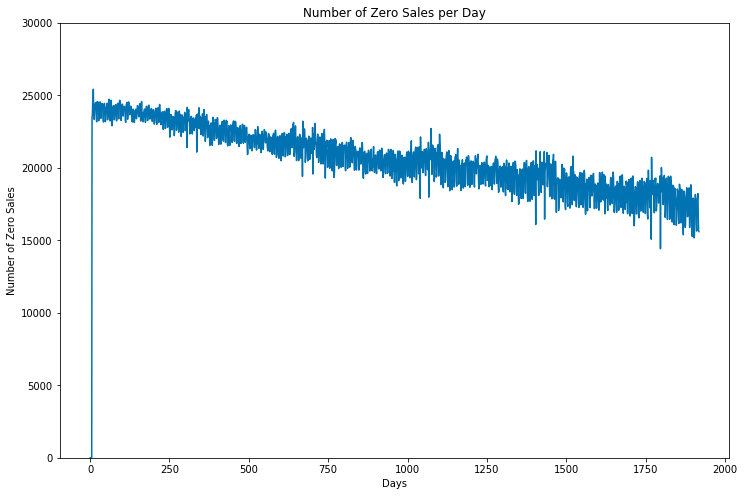

In [15]:
temp_series = df_train_no_outlier
plt.figure(figsize=(12,8))
x = np.count_nonzero(temp_series==0, axis=0)
plt.plot(x)
    
plt.title('Number of Zero Sales per Day')
plt.ylabel('Number of Zero Sales')
plt.xlabel('Days')
plt.ylim(0,30000)

In [16]:
del temp_series, peak_days_before, peak_days_after, peak_d, peak_days, peaks
del df_train

## Training stage

In [17]:
df_train_no_outlier.head()
#As seen in the table above, we are going to create the 12 Levels one after another through grouping statements

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [18]:
series_cols = df_train_no_outlier.columns[df_train_no_outlier.columns.str.contains("d_")].values
level_cols = df_train_no_outlier.columns[df_train_no_outlier.columns.str.contains("d_")==False].values

In [19]:
#Now, we need to test, whether the combination of the levels is right and the rows contain the same input.
#We are going to do this by comparing the row names.

In [20]:
Level1 = pd.DataFrame(df_train_no_outlier[series_cols].sum(),columns={'Total'}).T
Level2 = df_train_no_outlier.groupby("state_id")[series_cols].sum()
Level3 = df_train_no_outlier.groupby("store_id")[series_cols].sum()
Level4 = df_train_no_outlier.groupby("cat_id")[series_cols].sum()
Level5 = df_train_no_outlier.groupby("dept_id")[series_cols].sum()

Level6 = df_train_no_outlier.groupby(["state_id",'cat_id'])[series_cols].sum().reset_index()
Level6['index']=''
for row in range(len(Level6)):
    Level6['index'][row]=str(Level6['state_id'][row])+'_'+str(Level6['cat_id'][row])
Level6.set_index(Level6['index'],inplace=True)
Level6.drop(['state_id','cat_id','index'],axis=1,inplace=True)

Level7 = df_train_no_outlier.groupby(["state_id",'dept_id'])[series_cols].sum().reset_index()
Level7['index']=''
for row in range(len(Level7)):
    Level7['index'][row]=str(Level7['state_id'][row])+'_'+str(Level7['dept_id'][row])
Level7.set_index(Level7['index'],inplace=True)
Level7.drop(['state_id','dept_id','index'],axis=1,inplace=True)

Level8 = df_train_no_outlier.groupby(["store_id",'cat_id'])[series_cols].sum().reset_index()
Level8['index']=''
for row in range(len(Level8)):
    Level8['index'][row]=str(Level8['store_id'][row])+'_'+str(Level8['cat_id'][row])
Level8.set_index(Level8['index'],inplace=True)
Level8.drop(['store_id','cat_id','index'],axis=1,inplace=True)

Level9 = df_train_no_outlier.groupby(["store_id",'dept_id'])[series_cols].sum().reset_index()
Level9['index']=''
for row in range(len(Level9)):
    Level9['index'][row]=str(Level9['store_id'][row])+'_'+str(Level9['dept_id'][row])
Level9.set_index(Level9['index'],inplace=True)
Level9.drop(['store_id','dept_id','index'],axis=1,inplace=True)

Level10= df_train_no_outlier.groupby(["item_id"])[series_cols].sum()


Level11= df_train_no_outlier.groupby(["item_id",'state_id'])[series_cols].sum().reset_index()
Level11['index']=''
for row in range(len(Level11)):
    Level11['index'][row]=str(Level11['item_id'][row])+'_'+str(Level11['state_id'][row])
Level11.set_index(Level11['index'],inplace=True)
Level11.drop(['item_id','state_id','index'],axis=1,inplace=True)


Level12= df_train_no_outlier.copy()
Level12.set_index(Level12['id'],inplace=True, drop =True)
Level12.drop(level_cols,axis=1,inplace=True)

df=pd.concat([Level1,Level2,Level3,Level4,Level5,Level6,Level7,Level8,Level9,Level10,Level11,Level12])

del Level1,Level2,Level3,Level4,Level5,Level6,Level7,Level8,Level9,Level10,Level11,Level12

In [21]:
submission_sample =pd.read_csv('m5-forecasting-uncertainty/sample_submission.csv')
test = pd.concat([df.reset_index()['index'],submission_sample.reset_index().id[:42840]],axis=1)
test
test['index'].replace('_validation','',regex=True,inplace=True)

In [22]:
test['proof'] = ''
for row in range(len(test)):
    if test['index'][row] in test['id'][row]:
        test['proof'][row]=True
test[test['proof']==False]

,index,id,proof


In [23]:
del test

## Feature engineering

## Feature Creation

In [24]:
df_days["date"] = pd.to_datetime(df_days['date'])
df_days.set_index('date', inplace=True)

df_days['is_event_day'] = [1 if x ==False else 0 for x in df_days['event_name_1'].isnull()] 
df_days['is_event_day'] = df_days['is_event_day'].astype(np.int8)

day_before_event = df_days[df_days['is_event_day']==1].index.shift(-1,freq='D')
df_days['is_event_day_before'] = 0
df_days['is_event_day_before'][df_days.index.isin(day_before_event)] = 1
df_days['is_event_day_before'] = df_days['is_event_day_before'].astype(np.int8)

del day_before_event

daysBeforeEventTest = df_days['is_event_day_before'][1913:1941]
daysBeforeEvent = df_days['is_event_day_before'][startDay:1913]
daysBeforeEvent.index = df_train_no_outlier.index[startDay:1913]

In [25]:
df_final = pd.concat([df.T.reset_index(drop=True), daysBeforeEvent.reset_index(drop=True)], axis = 1)
df_final = df_final[startDay:]

## Other Features

In [26]:
df_days

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_event_day,is_event_day_before
date,,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,0,0
2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,0,0
2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0,0
2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0,0
2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1,0,0
2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0,0,0
2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0,0,0


In [27]:
features = df_days[['is_event_day_before','wday','snap_CA','snap_TX','snap_WI']]
features.head()

,is_event_day_before,wday,snap_CA,snap_TX,snap_WI
date,,,,,
2011-01-29,0,1,0,0,0
2011-01-30,0,2,0,0,0
2011-01-31,0,3,0,0,0
2011-02-01,0,4,1,1,0
2011-02-02,0,5,1,0,1


In [28]:
# adding 'id' column as well as 'cat_id', 'dept_id' and 'state_id', then changing the type to 'categorical'
df_prices.loc[:, "id"] = df_prices.loc[:, "item_id"] + "_" + df_prices.loc[:, "store_id"] + "_validation"
df_prices['state_id'] = df_prices['store_id'].str.split('_',expand=True)[0]
df_prices = pd.concat([df_prices, df_prices["item_id"].str.split("_", expand=True)], axis=1)
df_prices = df_prices.rename(columns={0:"cat_id", 1:"dept_id"})
df_prices[["store_id", "item_id", "cat_id", "dept_id", 'state_id']] = df_prices[["store_id","item_id", "cat_id", "dept_id", 'state_id']].astype("category")
df_prices = df_prices.drop(columns=2)

In [29]:
price_features = pd.DataFrame(df_prices.groupby(['wm_yr_wk','store_id','cat_id'])['sell_price'].mean().reset_index())
price_features['sell_price'] = price_features['sell_price'].astype('float32')

In [30]:
price_features['store_cat'] = 0

for row in range(len(price_features)):
     price_features['store_cat'][row]=str(price_features['store_id'][row])+'_'+str(price_features['cat_id'][row])

In [31]:
price_features= price_features.pivot(index='store_cat',columns='wm_yr_wk',values='sell_price').T
price_features.head()

store_cat,CA_1_FOODS,CA_1_HOBBIES,CA_1_HOUSEHOLD,CA_2_FOODS,CA_2_HOBBIES,CA_2_HOUSEHOLD,CA_3_FOODS,CA_3_HOBBIES,CA_3_HOUSEHOLD,CA_4_FOODS,CA_4_HOBBIES,CA_4_HOUSEHOLD,TX_1_FOODS,TX_1_HOBBIES,TX_1_HOUSEHOLD,TX_2_FOODS,TX_2_HOBBIES,TX_2_HOUSEHOLD,TX_3_FOODS,TX_3_HOBBIES,TX_3_HOUSEHOLD,WI_1_FOODS,WI_1_HOBBIES,WI_1_HOUSEHOLD,WI_2_FOODS,WI_2_HOBBIES,WI_2_HOUSEHOLD,WI_3_FOODS,WI_3_HOBBIES,WI_3_HOUSEHOLD
wm_yr_wk,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11101,3.148438,4.468750,5.414062,2.876953,4.605469,5.558594,3.042969,4.585938,5.613281,2.953125,5.054688,5.457031,2.949219,4.675781,5.320312,2.957031,4.691406,5.460938,2.929688,4.742188,5.292969,2.759766,4.632812,5.472656,2.806641,4.871094,5.464844,2.988281,4.523438,5.261719
11102,3.154297,4.406250,5.507812,2.878906,4.597656,5.632812,3.058594,4.558594,5.632812,3.050781,5.109375,5.617188,2.982422,4.667969,5.441406,2.988281,4.640625,5.468750,2.984375,4.722656,5.468750,2.802734,4.695312,5.601562,2.861328,4.882812,5.703125,3.023438,4.625000,5.382812
11103,3.128906,4.460938,5.578125,2.869141,4.519531,5.597656,3.070312,4.488281,5.675781,3.058594,5.015625,5.625000,2.984375,4.585938,5.468750,2.988281,4.605469,5.558594,3.003906,4.742188,5.515625,2.832031,4.554688,5.593750,2.859375,4.808594,5.769531,3.058594,4.550781,5.433594
11104,3.123047,4.421875,5.578125,2.861328,4.527344,5.589844,3.078125,4.488281,5.664062,3.064453,5.011719,5.667969,2.984375,4.542969,5.476562,2.990234,4.550781,5.546875,2.998047,4.746094,5.566406,2.822266,4.531250,5.632812,2.880859,4.761719,5.812500,3.056641,4.496094,5.515625
11105,3.126953,4.433594,5.566406,2.853516,4.539062,5.593750,3.082031,4.468750,5.687500,3.070312,5.003906,5.664062,2.974609,4.550781,5.539062,2.984375,4.476562,5.570312,2.990234,4.750000,5.585938,2.820312,4.515625,5.671875,2.888672,4.753906,5.839844,3.041016,4.492188,5.507812


In [32]:
features = df_days[['wm_yr_wk','is_event_day_before','wday','snap_CA','snap_TX','snap_WI']]
features.head()
features = pd.merge(features.reset_index(),price_features,how='left', left_on='wm_yr_wk', right_on='wm_yr_wk').set_index('date')
features.drop('wm_yr_wk', axis=1, inplace=True)
features.head()

,is_event_day_before,wday,snap_CA,snap_TX,snap_WI,CA_1_FOODS,CA_1_HOBBIES,CA_1_HOUSEHOLD,CA_2_FOODS,CA_2_HOBBIES,CA_2_HOUSEHOLD,CA_3_FOODS,CA_3_HOBBIES,CA_3_HOUSEHOLD,CA_4_FOODS,CA_4_HOBBIES,CA_4_HOUSEHOLD,TX_1_FOODS,TX_1_HOBBIES,TX_1_HOUSEHOLD,TX_2_FOODS,TX_2_HOBBIES,TX_2_HOUSEHOLD,TX_3_FOODS,TX_3_HOBBIES,TX_3_HOUSEHOLD,WI_1_FOODS,WI_1_HOBBIES,WI_1_HOUSEHOLD,WI_2_FOODS,WI_2_HOBBIES,WI_2_HOUSEHOLD,WI_3_FOODS,WI_3_HOBBIES,WI_3_HOUSEHOLD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,1,0,0,0,3.148438,4.46875,5.414062,2.876953,4.605469,5.558594,3.042969,4.585938,5.613281,2.953125,5.054688,5.457031,2.949219,4.675781,5.320312,2.957031,4.691406,5.460938,2.929688,4.742188,5.292969,2.759766,4.632812,5.472656,2.806641,4.871094,5.464844,2.988281,4.523438,5.261719
2011-01-30,0,2,0,0,0,3.148438,4.46875,5.414062,2.876953,4.605469,5.558594,3.042969,4.585938,5.613281,2.953125,5.054688,5.457031,2.949219,4.675781,5.320312,2.957031,4.691406,5.460938,2.929688,4.742188,5.292969,2.759766,4.632812,5.472656,2.806641,4.871094,5.464844,2.988281,4.523438,5.261719
2011-01-31,0,3,0,0,0,3.148438,4.46875,5.414062,2.876953,4.605469,5.558594,3.042969,4.585938,5.613281,2.953125,5.054688,5.457031,2.949219,4.675781,5.320312,2.957031,4.691406,5.460938,2.929688,4.742188,5.292969,2.759766,4.632812,5.472656,2.806641,4.871094,5.464844,2.988281,4.523438,5.261719
2011-02-01,0,4,1,1,0,3.148438,4.46875,5.414062,2.876953,4.605469,5.558594,3.042969,4.585938,5.613281,2.953125,5.054688,5.457031,2.949219,4.675781,5.320312,2.957031,4.691406,5.460938,2.929688,4.742188,5.292969,2.759766,4.632812,5.472656,2.806641,4.871094,5.464844,2.988281,4.523438,5.261719
2011-02-02,0,5,1,0,1,3.148438,4.46875,5.414062,2.876953,4.605469,5.558594,3.042969,4.585938,5.613281,2.953125,5.054688,5.457031,2.949219,4.675781,5.320312,2.957031,4.691406,5.460938,2.929688,4.742188,5.292969,2.759766,4.632812,5.472656,2.806641,4.871094,5.464844,2.988281,4.523438,5.261719


In [33]:
features_test = features.iloc[1913:1941,:]
features_train = features.iloc[startDay:1913,:]
df_final_more = pd.concat([df.T.reset_index(drop=True), features_train.reset_index(drop=True)], axis = 1)
df_final = df_final_more.copy()

In [34]:
del df_final_more, features

## Feature Scaling

In [35]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

In [36]:
dt_scaled = sc.fit_transform(df_final)

In [37]:
gc.collect()

25

## Generate Train and Test Data

In [38]:
X_train = []
y_train = []
for i in range(timesteps, 1913 - startDay):
    X_train.append(dt_scaled[i-timesteps:i])
    y_train.append(dt_scaled[i][0:42840]) 
    
X_train = np.array(X_train)
y_train = np.array(y_train)
print('Shape of X_train :'+str(X_train.shape))
print('Shape of y_train :'+str(y_train.shape))

Shape of X_train :(1899, 14, 42875)
Shape of y_train :(1899, 42840)


In [39]:
inputs = df_final[-timesteps:]
inputs = sc.transform(inputs)

In [40]:
del df_train_no_outlier, df_prices, df_days, df, df_final, dt_scaled, price_features

In [41]:
gc.collect()

218

## lstm Model

In [42]:
def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), 
                              axis=-1)

In [43]:
QUANTILES = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [44]:
EPOCHS = 32 # going through the dataset 32 times
BATCH_SIZE = 32 # with each training step the model sees 32 examples

In [45]:
! pip install tensorflow_probability -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [46]:
# Importing the Keras libraries and packages
import tensorflow_probability as tfp
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
import keras

def run_model(X_train, y_train, q):

    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    layer_1_units=40
    model.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    layer_2_units=300
    model.add(LSTM(units = layer_2_units, return_sequences = True))
    model.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    layer_3_units=300
    model.add(LSTM(units = layer_3_units))
    model.add(Dropout(0.2))

    # Adding the output layer
    model.add(Dense(units = y_train.shape[1]))

    # Compiling the RNN
    model.compile(optimizer = 'adam',loss=lambda y, f: tilted_loss(q, y, f))
    
    # To follow at which quantile we are predicting right now  
    print('Running the model for Quantil: '+str(q)+':')

    # Fitting the RNN to the Training set
    fit = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose=2)
    
    X_test = []
    X_test.append(inputs[0:timesteps])
    X_test = np.array(X_test)
    prediction = []
     
    for j in range(timesteps,timesteps + 28):
        predicted_volume = model.predict(X_test[0,j - timesteps:j].reshape(1, timesteps, 42875)) #incl. features
        testInput = np.column_stack((np.array(predicted_volume), np.array(features_test.iloc[j-timesteps,:]).reshape(1,35))) #here no of features is 5
        X_test = np.append(X_test, testInput).reshape(1,j + 1,42875) #incl. features
        predicted_volume = sc.inverse_transform(testInput)[:,0:42840] #without features
        prediction.append(predicted_volume)
    
    prediction = pd.DataFrame(data=np.array(prediction).reshape(28,42840)).T
    return prediction

Using TensorFlow backend.


In [47]:
# We run the model for all the quantiles mentioned above. 
# Combining all quantile predictions one after another to a large dataset.
predictions = pd.concat(
    [run_model(X_train, y_train, q) 
     for q in QUANTILES]) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Running the model for Quantil: 0.005:
Instructions for updating:
Use tf.cast instead.
Epoch 1/32
 - 51s - loss: 4.8171e-04
Epoch 2/32
 - 47s - loss: 4.4931e-04
Epoch 3/32
 - 47s - loss: 4.4246e-04
Epoch 4/32
 - 47s - loss: 4.4725e-04
Epoch 5/32
 - 46s - loss: 4.5201e-04
Epoch 6/32
 - 46s - loss: 4.5320e-04
Epoch 7/32
 - 45s - loss: 4.5343e-04
Epoch 8/32
 - 46s - loss: 4.5309e-04
Epoch 9/32
 - 45s - loss: 4.5328e-04
Epoch 10/32
 - 46s - loss: 4.5343e-04
Epoch 11/32
 - 46s - loss: 4.5332e-04
Epoch 12/32
 - 46s - loss: 4.5338e-04
Epoch 13/32
 - 46s - loss: 4.5331e-04
Epoch 14/32
 - 46s - loss: 4.5319e-04
Epoch 15/32
 - 46s - loss: 4.5317e-04
Epoch 16/32
 - 46s - loss: 4.5326e-04
Epoch 17/32
 - 46s - loss: 4.5319e-04
Epoch 18/32
 - 45s - loss: 4.5334e-04
Epoch 19/32
 - 45s - loss: 4.5327e-04
Epoch 20/32
 -

 - 49s - loss: 0.0354
Epoch 15/32
 - 49s - loss: 0.0354
Epoch 16/32
 - 48s - loss: 0.0353
Epoch 17/32
 - 48s - loss: 0.0353
Epoch 18/32
 - 48s - loss: 0.0353
Epoch 19/32
 - 48s - loss: 0.0353
Epoch 20/32
 - 49s - loss: 0.0353
Epoch 21/32
 - 48s - loss: 0.0353
Epoch 22/32
 - 48s - loss: 0.0353
Epoch 23/32
 - 49s - loss: 0.0353
Epoch 24/32
 - 49s - loss: 0.0352
Epoch 25/32
 - 48s - loss: 0.0353
Epoch 26/32
 - 48s - loss: 0.0352
Epoch 27/32
 - 49s - loss: 0.0353
Epoch 28/32
 - 48s - loss: 0.0352
Epoch 29/32
 - 48s - loss: 0.0352
Epoch 30/32
 - 48s - loss: 0.0352
Epoch 31/32
 - 48s - loss: 0.0352
Epoch 32/32
 - 48s - loss: 0.0352
Running the model for Quantil: 0.975:
Epoch 1/32
 - 56s - loss: 0.0350
Epoch 2/32
 - 49s - loss: 0.0117
Epoch 3/32
 - 48s - loss: 0.0117
Epoch 4/32
 - 48s - loss: 0.0117
Epoch 5/32
 - 48s - loss: 0.0117
Epoch 6/32
 - 48s - loss: 0.0117
Epoch 7/32
 - 48s - loss: 0.0117
Epoch 8/32
 - 48s - loss: 0.0117
Epoch 9/32
 - 48s - loss: 0.0116
Epoch 10/32
 - 48s - loss: 0.01

In [48]:
gc.collect()

101

In [49]:
predictions.shape

(385560, 28)

In [50]:
predictions.shape[0]*2

771120

In [51]:
predictions.to_pickle('Uncertainty_Predictions.pkl')

In [52]:
submission = pd.concat((predictions, predictions), ignore_index=True)
idColumn = submission_sample[["id"]]    
submission[["id"]] = idColumn  

#re-arranging collumns
cols = list(submission.columns)
cols = cols[-1:] + cols[:-1]
submission = submission[cols]
#
colsname = ["id"] + [f"F{i}" for i in range (1,29)]
submission.columns = colsname

submission.to_csv("submission.csv", index=False)

In [53]:
temp_series = submission[171360:171360+42840]

border = [1,3,10,3,7,9,21,30,70,3049,9147,30490]
sumi = 0
levels =[]
for i in border:
    sumi += i
    levels.append(pd.DataFrame(temp_series[sumi-i:sumi]))


for i,level in enumerate(levels):
    levels[i] = levels[i].sum()

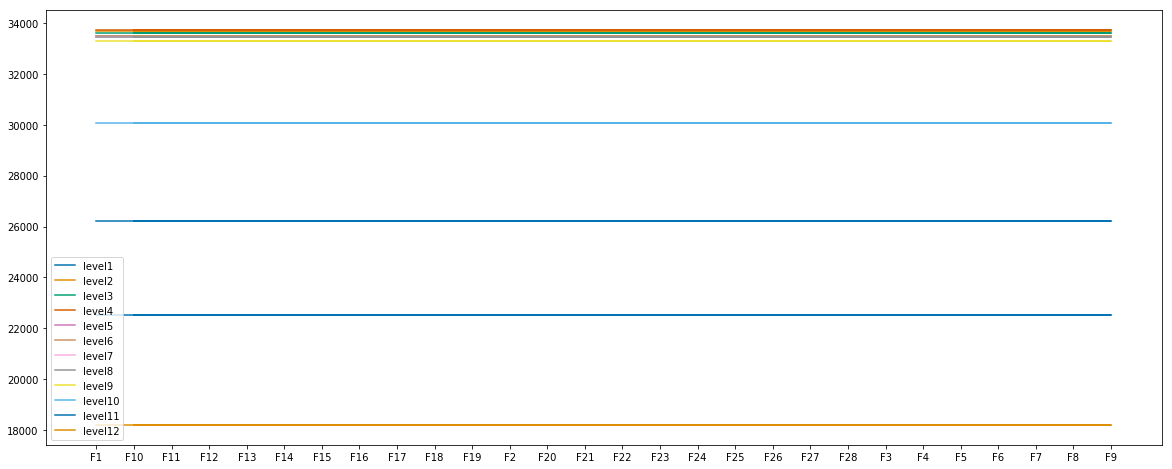

In [54]:
plt.figure(figsize=(20, 8))

for i in range(12):
    plt.plot(levels[i][1:],label='level'+str(i+1))

plt.legend()

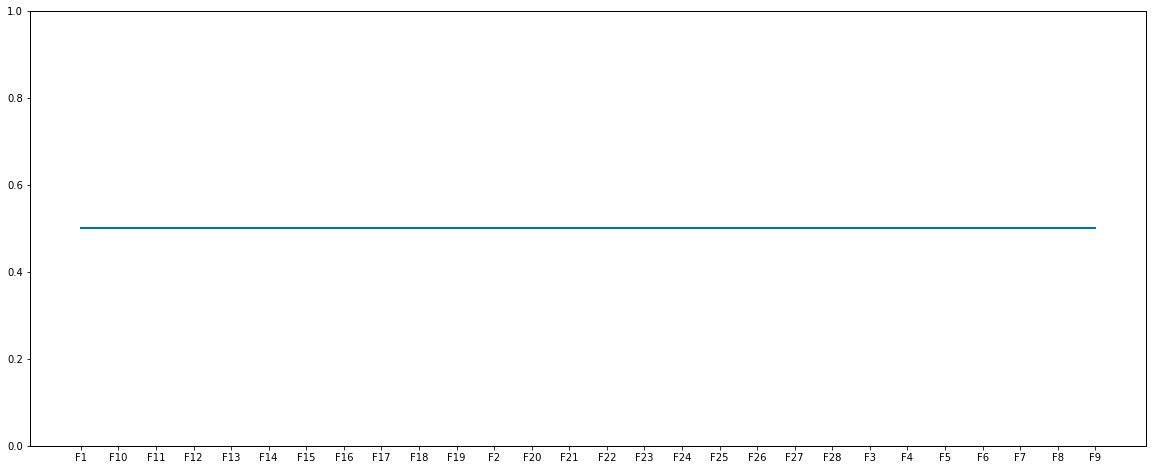

In [55]:
fig,ax = plt.subplots(figsize=(20, 8))

for i in range(6):
    ax = ax.twinx()
    ax.plot(levels[i][1:],label='level'+str(i+1))
    plt.yticks([])